In [1]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.files.fasta import FASTAFile
from Bio import Phylo
from itertools import product, combinations
from utils import *
from src.coevolution import get_scores
from scipy.stats import mannwhitneyu
from src.files.itol import *
import io 

%load_ext autoreload 
%autoreload 2

is_homogenous = lambda df : df.category.nunique() == 1

In [2]:
# Want to compare the regions where the divergence scores are highest. Would expect to see higher divergence scores around
# the N-terminus when comparing Pyl+ vs. Pyl-. Probably should control for evolutionary distance, i.e. compare clades which are similarly
# distant. Probably the easiest way to do this is by clustering the release factors and then building a tree of the representatives. 

arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)
# build_stop_codon_genome_metadata_dataset(arf1_df.genome_id.unique())
stop_codon_genome_metadata_df = pd.read_csv('../data/arf1_stop_codon_metadata.csv', index_col=0)

arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count


# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers

masks = dict()
masks['pyl+'] = (arf1_df.tag_percent < 0.05) & (arf1_df.has_pyl)
masks['pyl-'] = (~arf1_df.has_pyl)

categories = list(masks.keys())
arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')
print('Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories:', (arf1_df.category == 'none').sum())
arf1_df = arf1_df[arf1_df.category != 'none'].copy()

Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories: 73


In [3]:
# I think the clustering approach from sandbox-1 is flawed, because it is pretty clear that aRF1 similarity might not track phylogeny. 
# By clustering by aRF1 similarity, I am kind of defeating the purpose of controlling for phylogeny in the comparisons. I think 
# instead of clustering, it might make more sense to count the number of significant mutations between similarly-related organisms
# in different categories. 

In [4]:
def get_distances(arf1_df, tree, max_distance=2.5):

    arf1_df = arf1_df.copy()
    arf1_df['protein_id'] = arf1_df.index 
    arf1_df = arf1_df.set_index('genome_id') # Need to use the genome ID as an index to work with the tree. 

    # Precompute the distances to the roots. 
    leaves = [tree.find_any(genome_id) for genome_id in arf1_df.index]
    distances_to_root = {leaf:tree.distance(tree.root, leaf) for leaf in leaves} # Can use the clade objects themselves as keys. 

    distance_df = list()

    for leaf_1, leaf_2 in tqdm(list(combinations(leaves, 2)), desc='get_distances'):
        genome_id_1, genome_id_2 = leaf_1.name, leaf_2.name 
        row = {'genome_id_1':leaf_1.name, 'genome_id_2':leaf_2.name}

        lca = tree.common_ancestor(leaf_1, leaf_2) # Using the LCA to get distance is *much* faster (thanks ChatGPT)... should look into why. 
        lca_distance_to_root = distances_to_root.get(lca, tree.distance(tree.root, lca)) # Only compute the distance if it's not already in the dictionary. 
        distances_to_root[lca] = lca_distance_to_root # Store in the lookup table. 
        distance = distances_to_root[leaf_1] + distances_to_root[leaf_2] - (2 * lca_distance_to_root)

        if distance < max_distance:
            row['distance'] = distance 
            row['category_1'], row['category_2'] = arf1_df.loc[genome_id_1].category, arf1_df.loc[genome_id_2].category
            row['protein_id_1'], row['protein_id_2'] = arf1_df.loc[genome_id_1].protein_id, arf1_df.loc[genome_id_2].protein_id
            row['category'] = ' vs. '.join(sorted([row['category_1'], row['category_2']]))
            distance_df.append(row) # Only add if the distance is not too far. 

    distance_df = pd.DataFrame(distance_df)
    return distance_df

tree = load_ar53_tree(genome_ids=arf1_df.genome_id.unique())

if os.path.exists('../data/arf1_tree_distances_ar53.csv'):
    distance_df = get_distances(arf1_df, tree)
    distance_df.to_csv('../data/arf1_tree_distances_ar53.csv')
distance_df = pd.read_csv('../data/arf1_tree_distances_ar53.csv', index_col=0)

protein_ids = np.unique(distance_df.protein_id_1.tolist() + distance_df.protein_id_2.tolist())

align_df = pd.read_csv('../data/arf1_cleaned_align.tsv', usecols=[0, 1, 2, 3], sep='\t', names=['query_id', 'target_id', 'e_value', 'percent_identity'])
percent_identity_map = align_df.set_index(["query_id", "target_id"])["percent_identity"].to_dict()

get_distances: 100%|██████████| 2917320/2917320 [44:10<00:00, 1100.57it/s] 


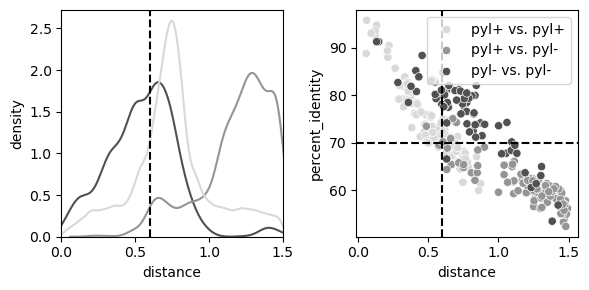

In [5]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(6, 3), ncols=2)

figure_df = list()
for row in distance_df[distance_df.distance < 1.5].itertuples():
    row_ = {'category':row.category}
    row_['distance'] = row.distance 
    row_['percent_identity'] = percent_identity_map.get((row.protein_id_1, row.protein_id_2))
    figure_df.append(row_)
figure_df = pd.DataFrame(figure_df)

sns.kdeplot(figure_df, hue='category', palette='Grays', x='distance', common_norm=False, ax=ax_a, legend=False)
ax_a.set_xlim(xmin=0, xmax=1.5)
ax_a.set_ylabel('density')
ax_a.axvline(0.6, ls='--', color='black')

sns.scatterplot(figure_df.groupby('category').apply(lambda x: x.sample(n=100, random_state=42), include_groups=False) , x='distance', y='percent_identity', hue='category', palette='Grays', ax=ax_b)
ax_b.legend().set_title('')
ax_b.axhline(70, ls='--', color='black')
ax_b.axvline(0.6, ls='--', color='black')

fig.tight_layout()
plt.show()

In [6]:
max_distance = 0.7
min_distance = 0.5
delta = 0.02

mask = distance_df.distance < max_distance
protein_ids = distance_df[mask].protein_id_1.tolist() + distance_df[mask].protein_id_2.tolist()
protein_ids = np.unique(protein_ids)

def sample(ref_distances, distance_df, delta=delta, n:int=10):
    sample_df = list()
    for distance in ref_distances:
        mask = (distance_df.distance < distance + delta) & (distance_df.distance > distance - delta)
        sample_df.append(distance_df[mask].sample(n, replace=True).copy())
    sample_df = pd.concat(sample_df)
    return sample_df 

ref_distances = distance_df[mask & (distance_df.category == 'pyl+ vs. pyl-')].distance.values 

sampled_distance_df = [distance_df[mask & (distance_df.category == 'pyl+ vs. pyl-')].copy()]
sampled_distance_df += [sample(ref_distances, distance_df[distance_df.category == 'pyl- vs. pyl-'])]
sampled_distance_df += [sample(ref_distances, distance_df[distance_df.category == 'pyl+ vs. pyl+'])]
sampled_distance_df = pd.concat(sampled_distance_df)
sampled_distance_df = sampled_distance_df.drop_duplicates(['genome_id_1', 'genome_id_2'])


In [7]:
def _annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')

index, alignment = load_msa('../data/arf1_cleaned.afa', ids=protein_ids)
alignment_df = pd.DataFrame(alignment, index=index)

seq = ''.join(alignment[0])
domain_boundaries = get_domain_boundaries(seq)

get_domain_boundaries: NIKS boundaries 55-59.
get_domain_boundaries: YxCxxxF boundaries 119-126.
get_domain_boundaries: GTS boundaries 23-26.


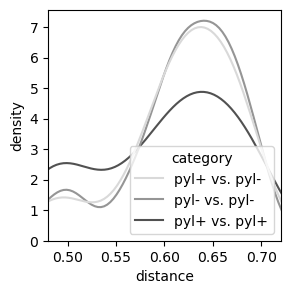

Num. pyl+ vs. pyl+ pairs in sample: 956
Num. pyl+ vs. pyl- pairs in sample: 282
Num. pyl- vs. pyl- pairs in sample: 2757


In [8]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.kdeplot(sampled_distance_df, hue='category', palette='Grays', x='distance', common_norm=False, ax=ax, legend=True)
ax.set_xlim(xmin=min_distance - delta, xmax=max_distance + delta)
ax.set_ylabel('density')
plt.show()

for category, df in sampled_distance_df.groupby('category'):
    print(f'Num. {category} pairs in sample:', len(df))

In [9]:
index, alignment = load_msa('../data/arf1_cleaned.afa', ids=protein_ids)
alignment_df = pd.DataFrame(alignment, index=index)
# alignment_df = alignment_df.replace(dayhoff)

figure_df = list()
for row in sampled_distance_df.itertuples():
    mismatch_positions = np.where(alignment_df.loc[row.protein_id_1].values != alignment_df.loc[row.protein_id_2].values)[0]
    for position in mismatch_positions:
        figure_df.append({'category':row.category, 'position':position})
figure_df = pd.DataFrame(figure_df)

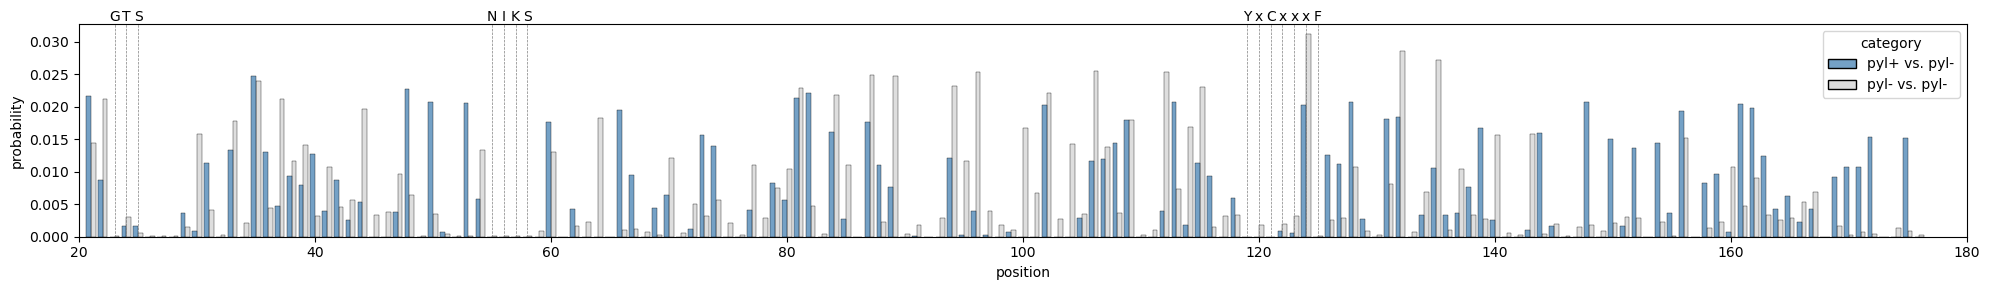

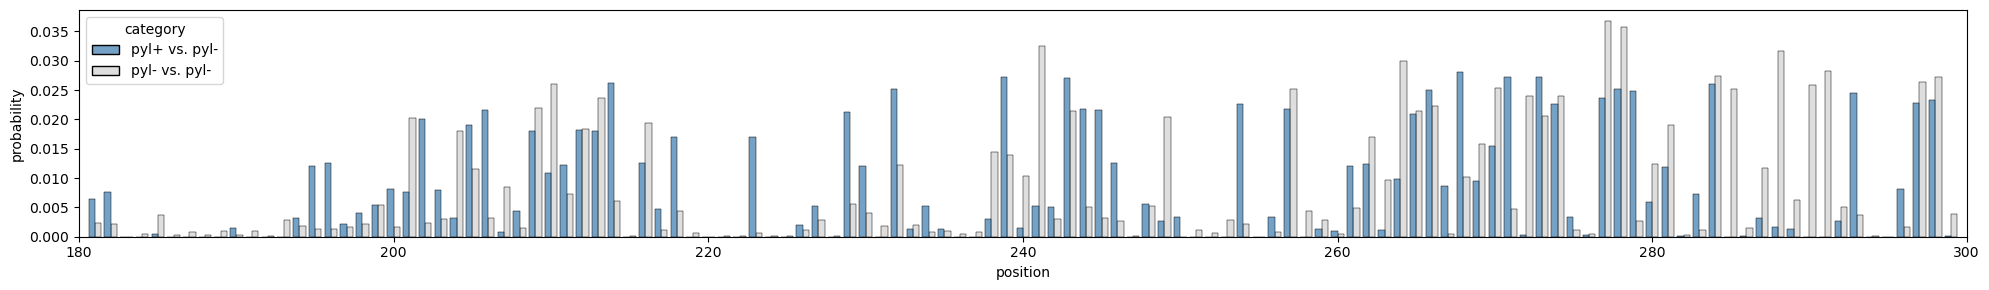

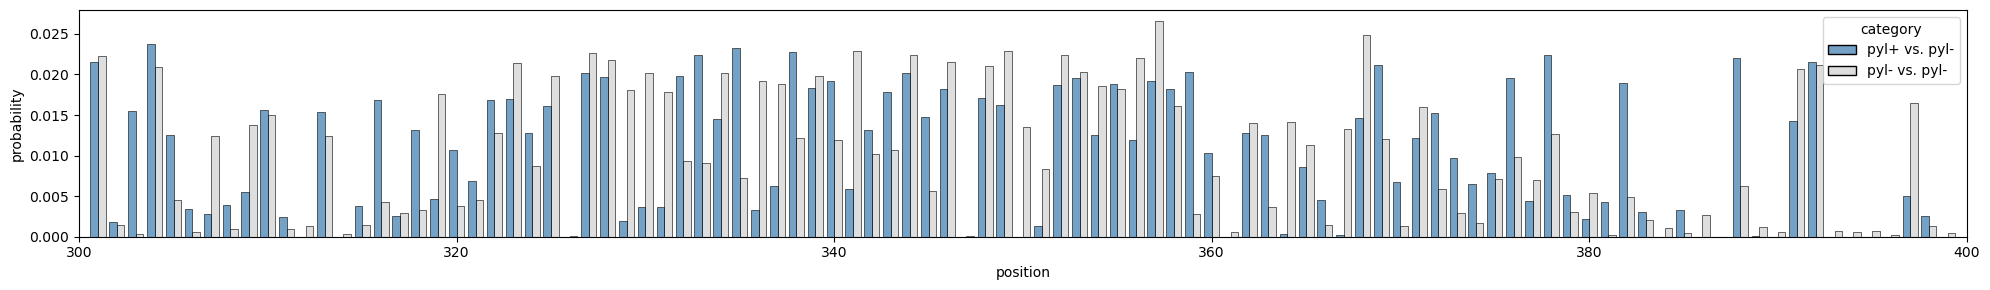

In [10]:
# values_1 = values_1[(values_1 > min_position) & (values_1 < max_position)]
# values_2 = values_2[(values_2 > min_position) & (values_2 < max_position)]
# stat, p = mannwhitneyu(values_1, values_2, alternative='two-sided')
# ax.text(0.02, 0.9, '$p_{MWU}=$' + f'{p:.4f}', transform=ax.transAxes)

def figure(min_position:int=30, max_position:int=55, exclude_pyl_plus:bool=False, annotate_residues:bool=False):
    fig, ax = plt.subplots(figsize=(20, 3))

    mask = (figure_df.position < max_position) & (figure_df.position > min_position)
    mask = mask & (figure_df.category != 'pyl+ vs. pyl+') if exclude_pyl_plus else mask
    palette = {'pyl- vs. pyl-':'lightgray', 'pyl+ vs. pyl+':'gray', 'pyl+ vs. pyl-':'steelblue'}
    sns.histplot(figure_df[mask], x='position', discrete=True, hue='category', stat='probability', common_norm=False, palette=palette, multiple='dodge', shrink=0.8)
    ax.set_ylabel('probability')
    ax.set_xlim(xmin=min_position, xmax=max_position)

    if annotate_residues:
        _annotate_residues(domain_boundaries, ax=ax)
        
    fig.tight_layout()
    plt.show()

c_domain = {'min_position':300, 'max_position':400}
n_domain = {'min_position':20, 'max_position':180}
m_domain = {'min_position':180, 'max_position':300}

figure(exclude_pyl_plus=True, annotate_residues=True, **n_domain)
figure(exclude_pyl_plus=True, **m_domain)
figure(exclude_pyl_plus=True, **c_domain)
# figure(min_position=90, max_position=130, exclude_pyl_plus=True)